### How long will it take to finish paying my mortgage?

We will make use of the `datetime` module to realistically keep track of facts about 
calendar time, in particular dates and the amounts of time separating them.

Specifically we'll answer two questions:

1.  How many months (payments) will it take for me to pay off my mortgage?
2.  Given a starting date, on what date will I finish paying off my mortgage?

In [4]:
from datetime import date,timedelta


# How I originally computed the payment start date
now0 = date.today()
# What Im doing to keep the computations in this notebook constant
now = date(2023, 8, 1)
# From a real mortage statment.  We will try to discover this date by computation.
last_payment = date(month=5,day=1,year=2027)
# For checking the results below
#mortgage_time_delta = (last_payment - now)
#num_days = mortgage_time_delta.days

# Used for updating current2, which is currently not being used
# The duration you mathematically add to a month to find one month later
app_days_in_month = 365.25/12
## datetime timedelta instance which represents a time delta (the result of subtracting two dates)
inc = timedelta(days=app_days_in_month)

# Another way of keeping track of current time in the loop.  Increment by estimated duration of a month
# Works but drifts off the real calendar for a payer paying every month
#current2 += inc

In [5]:
def increment_month (current):
    """
    For absolutely accurate calendric
    incrementing of months
    """
    next_month = (current.month%12)+1
    result = current.replace(month=next_month)
    if next_month == 1:
        result = result.replace(year=current.year+1)
    return result


# Provide these values.  Input to the computation
principle = 74_886.88
interest = .034
# Every month the amount owed grows by this factor
monthly_growth_factor = 1 + (interest/12)
# Every month the amount owed shrinks by this amount
pmt = 1774.96

In [6]:
# Initial values for variables to be updated in the loop
current = now  # We start making payments on this date
               # Also the answer to question 2 when we exit the loop below
owed = principle  #  We owe this amount to start with. Will be 0 when we exit the loop below
number_of_months = 0  #  We start with 0 months having passed
                      #  Also, the answer to question 1 when we exit the loop below.

while owed > 0:
    number_of_months += 1
    current = increment_month(current)
    owed *= monthly_growth_factor
    owed -= pmt

print(f"Mortgage will be paid off {current.strftime('%B %d, %Y')}")
print(f"Mortgage will be paid off in {number_of_months} months")
print(f"Sanity check: That's {((current-now).days)/app_days_in_month:.0f} months")

Mortgage will be paid off May 01, 2027
Mortgage will be paid off in 45 months
Sanity check: That's 45 months


Note that the last time through the loop the amount owed became negative.  That's all right.  In the real world, the last mortgage bill has a smaller payment amount to make it all come out dead even (`owed == 0`).

In [7]:
owed

-5.286549093633539

As a function:

In [8]:
def compute_number_of_months_and_payoff_date (now, principle, monthly_pmt, monthly_growth_factor):
    current = now 
    owed = principle   
    number_of_months = 0 
    while owed > 0:
        number_of_months += 1
        current = increment_month(current)
        owed *= monthly_growth_factor
        owed -= monthly_pmt
    return (current, number_of_months)

compute_number_of_months_and_payoff_date (now, principle, pmt, monthly_growth_factor)

(datetime.date(2027, 5, 1), 45)

### Revise to keep track of  interest and principle  paid month by month

Draw a plot: x axis is month number, y-axis is payment.  Two lines.
One for interest and one for principle.

In [11]:
import numpy as np

# Initial values for variables to be updated in the loop
current = now
owed = principle
number_of_months = 0
interest_pd = []
principle_pd = []
monthly_interest_rt = interest/12

ctr=0

while owed > 0:
    number_of_months += 1
    current = increment_month(current)
    interest_pd0 =  monthly_interest_rt * owed
    interest_pd.append(interest_pd0)
    principle_pd.append(pmt-interest_pd0) 
    #print(f"{interest_pd0:.2f} {pmt-interest_pd0:.2f}")
    owed += interest_pd0
    owed -= pmt
    ctr += 1
    if ctr > 50:
        break

interest_pd = np.array(interest_pd)
principle_pd = np.array(principle_pd)
print(f"Mortgage will be paid off {current.strftime('%B %d, %Y')}")
print(f"Mortgage will be paid off in {ctr} months")
print(f"Principle: ${principle_pd.sum():,.2f} Interest: ${interest_pd.sum():,.2f}")

Mortgage will be paid off May 01, 2027
Mortgage will be paid off in 45 months
Principle: $74,892.17 Interest: $4,981.03


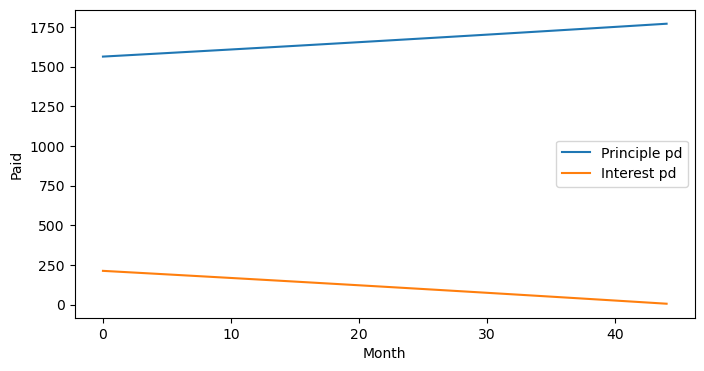

In [14]:
from matplotlib import pyplot as plt

(fig,ax) = plt.subplots(1,1,figsize=(8,4))
ax.plot(range(ctr),principle_pd,label="Principle pd")
ax.plot(range(ctr),interest_pd,label="Interest pd")
ax.set_xlabel("Month")
ax.set_ylabel("Paid")
plt.legend()

In [110]:
#def increment_month2 (current,num_months=1):
#    """
#    For calender-compatible
#    incrementing of months by number of months:
#    
##    feb  3, 2023 + 2 months = apr 3,2023
#     dec 12, 2023 + 2 months = feb 12, 2024
#    Still buggy
#    """
#    (year_inc,month_inc) = divmod(num_months,12)
#    result = current.replace(year=current.year+year_inc)
#    #new_month = ((result.month%12)+(month_inc%12))%12
#    new_month0 = (result.month + month_inc)
#    new_month = new_month0%12
#    try:
#        if new_month:
#            result = result.replace(month=new_month)
#    except ValueError as e:
#        print(new_month, result.month,month_inc,year_inc)
#        raise e
#    if new_month0 > 12:
#        result = result.replace(year=result.year+1)
#   return result

# For testing increment_month2
#print(new_month,result.month,month_inc,year_inc)
#for inc in range(45,26,-1):
#    print(inc, increment_month2 (now, num_months=inc))

### Compute the right payment for a given loan amount, loan term, and interest rate

Using $\kappa$ for the monthly growth factor and $\rho$ for the payment
and $\omicron_{n}$ for the amount owed at month $n$.

$$
\begin{array}[t]{lcl}
\omicron_{n} &=& (\kappa * \omicron_{n-1}) - \rho\\
\omicron_{n-1} &=& (\kappa * \omicron_{n-2}) - \rho\\
           & \dots &          \\
\omicron_{2} &=& (\kappa * \omicron_{1}) - \rho\\  
\omicron_{1} &=& (\kappa * \omicron_{0}) - \rho\\
\end{array}
$$

After n iterations

$$
\omicron_{n} = \omicron_{0}\kappa^{n}  - \rho \sum_{i=0}^{i=n-1}\kappa^{i}
$$

We are interested in finding the $\rho$ that makes $\omicron_{n}$
be 0.

$$
\begin{array}[t]{llcl}
(1) & \rho & = & \frac{\omicron_{0}\kappa^{n}}{\sum_{i=0}^{i=n-1} \kappa^{i}}
\end{array}
$$

In thinking of how to implement (1), we would probably make use of a closed-form solution for the power sum, which follows directly from the factoring of $x^{n} -1$:

$$
\begin{array}[t]{lcl}
x^{n} - 1 & = & (x - 1)(x^{n - 1} + x ^ {n -2} + \dots 1) \\
          & = & (x - 1) ( \sum^{n-1}_{i=0} x^i ) \\
 \frac{x^{n} - 1}{x - 1} & = &    \sum^{n-1}_{i=0} x^i
\end{array}
$$

In other words, 

$$
\begin{array}[t]{llcl}
(2) & \sum^{n-1}_{i=0} x^i & = & \frac{x^{n} - 1}{x - 1}  
\end{array}
$$

#### Task :  Write the function `compute_rho` that computes $\rho$ given $\omicron_{0}$, $\kappa$, and $n$

We will implement  `compute_rho` 
using formula (1),
but we will do it  two different ways, by computing the sum of powers
in the denominator two different ways:

Sketch

1.  Write a function `power_sum` to do the summing of powers in the denominator of (1). In other words:
    
    $$
    \text{power_sum}(x,n) = \sum^{n}_{i=0} x^i
    $$
    
2.  `power_sum` should be recursive and it should compute all the powers of $x$ from $x^{0}$ through $x^{n}$,
     and then sum them up.
3.  Write another function `power_sum2`, which uses  equation (2) to compute the sum of powers in the denominator of (1).
4.  Write two versions of `compute_rho` (`compute_rho` and `compute_rho2`), one which calls
    `power_sum` to compute (1), and one which calls `power_sum2`.

#### Solutions 

In [60]:
def power_sum (k,n):
    """
    Recursive computation of the sum of powers
    """
    if n < 0:
        raise Exception(f"Can't power sum negative powers k = {k} n = {n}")
    if n==0:
        return 1
    else:
        return k**n + power_sum(k, n-1)
    
def power_sum2 (k,n):
    """
    Function for the sum of powers
    """
    return (k ** (n+1) - 1)/(k -1)

In [65]:
for (x,n) in zip(range(2,10),range(3,12)):
    print(f"x: {x:<2} i: {n:<2}   {power_sum(x,n):>16,.2f}")
    print(f"x: {x:<2} i: {n:<2}   {power_sum2(x,n):>16,.2f}")
    print()

x: 2  i: 3               15.00
x: 2  i: 3               15.00

x: 3  i: 4              121.00
x: 3  i: 4              121.00

x: 4  i: 5            1,365.00
x: 4  i: 5            1,365.00

x: 5  i: 6           19,531.00
x: 5  i: 6           19,531.00

x: 6  i: 7          335,923.00
x: 6  i: 7          335,923.00

x: 7  i: 8        6,725,601.00
x: 7  i: 8        6,725,601.00

x: 8  i: 9      153,391,689.00
x: 8  i: 9      153,391,689.00

x: 9  i: 10   3,922,632,451.00
x: 9  i: 10   3,922,632,451.00



In [62]:
def compute_rho2 (owed, kappa, n):
    return (owed*(kappa**n))/(power_sum2(kappa,n-1))

def compute_rho (owed, kappa, n):
    return (owed*(kappa**n))/(power_sum(kappa,n-1))


Let's take a sitiuation (fixed loan amount,
fixed interest rate, fixed loan term) 
and compute the monthly payment that would be needed
in two differnt ways:

In [63]:
owed = 200_000
interest = .034
kappa = 1 + (interest/12)
# 30 year mortage
n = 12 * 30

rho1 = compute_rho(owed,kappa,n)
rho2 = compute_rho(owed,kappa,n)
print(f"rho1 ${rho1:.2f} rho2 ${rho2:.2f}")

rho1 $886.96 rho2 $886.96


So a monthly payment of about $886.96 would be needed.

We check this with the function we wrote above, which  will compute
the number of months and payoff date it takes to pay off the loan.  We want the number of months to be
$n$ (=360).  The function needs a start date:

In [66]:
now = date(2023, 8, 1)

# compute_number_of_months_and_date (now,principle, monthly_pmt, monthly_growth_factor):
compute_number_of_months_and_payoff_date (now, owed, rho1, kappa)

(datetime.date(2053, 8, 1), 360)

And all is well.  Payoff date is 30 years down the road, which is 360 months.

Answer the following questions and choose one of Qs 2 (interest rate), 3 (loan term), or 4 (total amount of interest) to draw a plot for.
The plot should show how the dependent variable ($\rho$ in Qs 1-3; total amount of interest in Q4) changes as the independent variable in the question changes.

Questions

1.  What happens to $\rho$ if the loan amount is doubled?  How do you know?
2.  What happens to $\rho$ if the interest rate is doubled?  
    Is the new value less than $2\rho$ or more than $2\rho$ or equal to $2\rho$?
3.  What happens to $\rho$ if the term of the loan is halved?  
    Is the new value less than $2\rho$ or more than $2\rho$ or equal to $2\rho$?
3.  What happens to the total amount of interest paid if the term of the loan is halved?  
    Is the new value less than twice the old value or more?